# Baixando a base de dados do Kaggle


In [ ]:
# baixando a lib do kaggle
!pip install --upgrade kaggle
!pip install plotly
# para visualizar dados faltantes
!pip install missingno

In [ ]:
# requisitando upload do token de autentificação do Kaggle

# OBS: o arquivo kaggle.json precisa ser baixado da sua conta pessoal do Kaggle.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn]) ))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
# alocando o arquivo kaggle.json em seu devido local e permitindo escrita e leitura no mesmo
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpreda/covid-world-vaccination-progress
!!unzip covid-world-vaccination-progress.zip -d data_folder

  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 20.4MB/s]


['Archive:  covid-world-vaccination-progress.zip',
 '  inflating: data_folder/country_vaccinations.csv  ']

# Código da análise exploratória em si


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import plotly.graph_objects as go
import matplotlib.ticker as ticker

In [ ]:
def gera_lista_vacinas(dataset):
    '''
    Gera uma lista com todas as vacinas do dataset
    input: DataFrame dos dados
    output: lista de todas as vacinas
    '''
    todas_vacinas = list(dataset.groupby(['vacinas']).count().index)

    conjunto_vacinas = set()
    for lista_vacinas in todas_vacinas:
        lista_vacinas = lista_vacinas.split(', ')

        for vacina in lista_vacinas:
            conjunto_vacinas.add(vacina)
    lista_vacinas = list(conjunto_vacinas)
    lista_vacinas.sort()

    return lista_vacinas


def gera_lista_paises(dataset):
    '''
    Gera a lista de países que estão em vacinação
    input: DataFrame dos dados
    output: lista de todos os países
    '''
    return list(dataset.groupby(['pais']).count().index)


def gera_dataframe_vacinas(dataset):
    '''
    Gera um novo DataFrame em que as vacinas antes eram listadas na coluna 'vacinas'
    agora são listadas entre 10 colunas correspondentes à cada vacina, com 0's e 1's.
    Os 1's representam que vacina está sendo aplicada naquele país, os 0's que não!

    input: DataFrame dos dados
    output: DataFrame dos dados das vacinas categorizados
    '''
    labels_vacinas = gera_lista_vacinas(dataset)   # lista das vacinas entendidas como labels
    dataset_vacinas = dataset['vacinas']

    array_temporario_vacinas = []     # inicia como uma lista vazia
    for linha_vacina in dataset_vacinas:
        sublista_vacinas = linha_vacina.split(', ')
        #lista de tamanho len(labels_vacinas) com 0's para elementos em sublista
        nova_linha = [int(vacina in sublista_vacinas) for vacina in labels_vacinas]
        array_temporario_vacinas.append(nova_linha)

    dataset_temporario_vacinas = pd.DataFrame(array_temporario_vacinas, columns=labels_vacinas)
    dataset.drop(columns=['vacinas'], axis=1, inplace=True)
    dataset = pd.concat([dataset, dataset_temporario_vacinas], axis=1)

    return dataset

In [ ]:
dataset = pd.read_csv(r'data_folder/country_vaccinations.csv')

nome_colunas = ['pais', 'codigo_iso', 'data', 'total_vacinacoes', 'pessoas_vacinadas',
                'pessoas_tot_vacinadas', 'vacinacoes_diarias_raw', 'vacinacoes_diarias',
                'tot_vacinacoes_por_cent', 'pessoas_vacinadas_por_cent', 'pessoas_tot_vacinadas_por_cent',
                'vacinacoes_diarias_por_milhao', 'vacinas', 'fonte_dados', 'website_fonte']
nome_colunas_antigo = list(dataset.columns)

dataset.rename(columns=dict(zip(nome_colunas_antigo, nome_colunas)), inplace=True)

In [ ]:
dataset.head()

,pais,codigo_iso,data,total_vacinacoes,pessoas_vacinadas,pessoas_tot_vacinadas,vacinacoes_diarias_raw,vacinacoes_diarias,tot_vacinacoes_por_cent,pessoas_vacinadas_por_cent,pessoas_tot_vacinadas_por_cent,vacinacoes_diarias_por_milhao,vacinas,fonte_dados,website_fonte
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


In [ ]:
# DATAFRAME COM AS INFOS DAS VACINAS
freq_vacinas = dataset.groupby('pais').max()

demais_colunas = [coluna for coluna in nome_colunas if coluna not in lista_vacinas and coluna not in ['pais', 'vacinas']]
freq_vacinas.drop(columns=demais_colunas, axis=1, inplace=True)

# para o bar plot vacinas x num_paises
densidade_vacinas = pd.DataFrame(freq_vacinas.sum(), columns=['num_paises']) 

In [ ]:
# BARPLOT DAS VACINAS
fig_disposicao_vacinas = plt.figure(figsize = (20, 10))
plt.title('Número de países que utilizam as vacinas', fontsize=18)

y_label = densidade_vacinas.index
x_label = densidade_vacinas['num_paises'].values

plt.bar(y_label, x_label)
plt.grid()

for i in range(len(x_label)):
    plt.annotate(str(x_label[i]), xy=(y_label[i], x_label[i]), ha='center', va='bottom', fontsize=14)

plt.show()

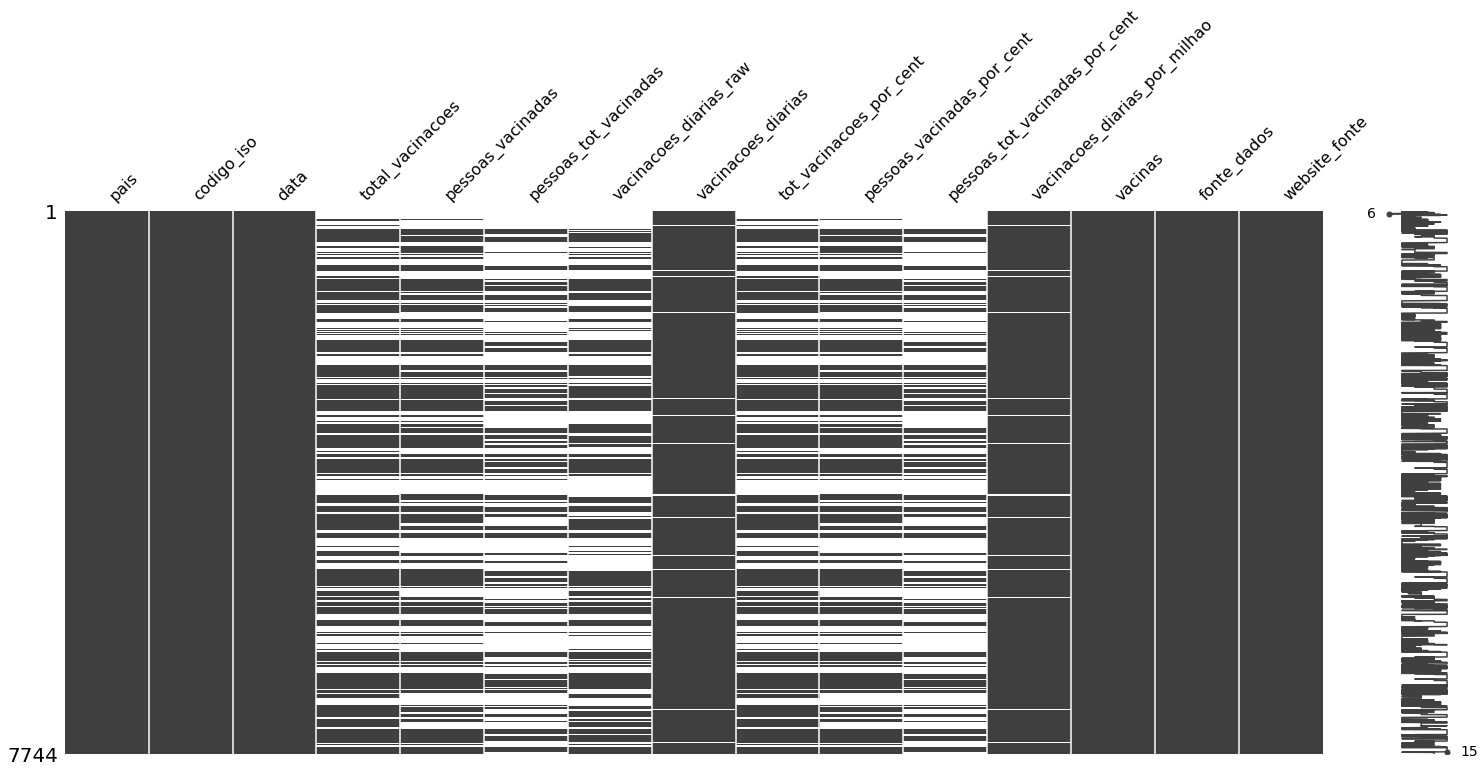

In [ ]:
# dados faltantes de todo o banco de dados
msno.matrix(dataset)

/usr/local/lib/python3.7/dist-packages/missingno/missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



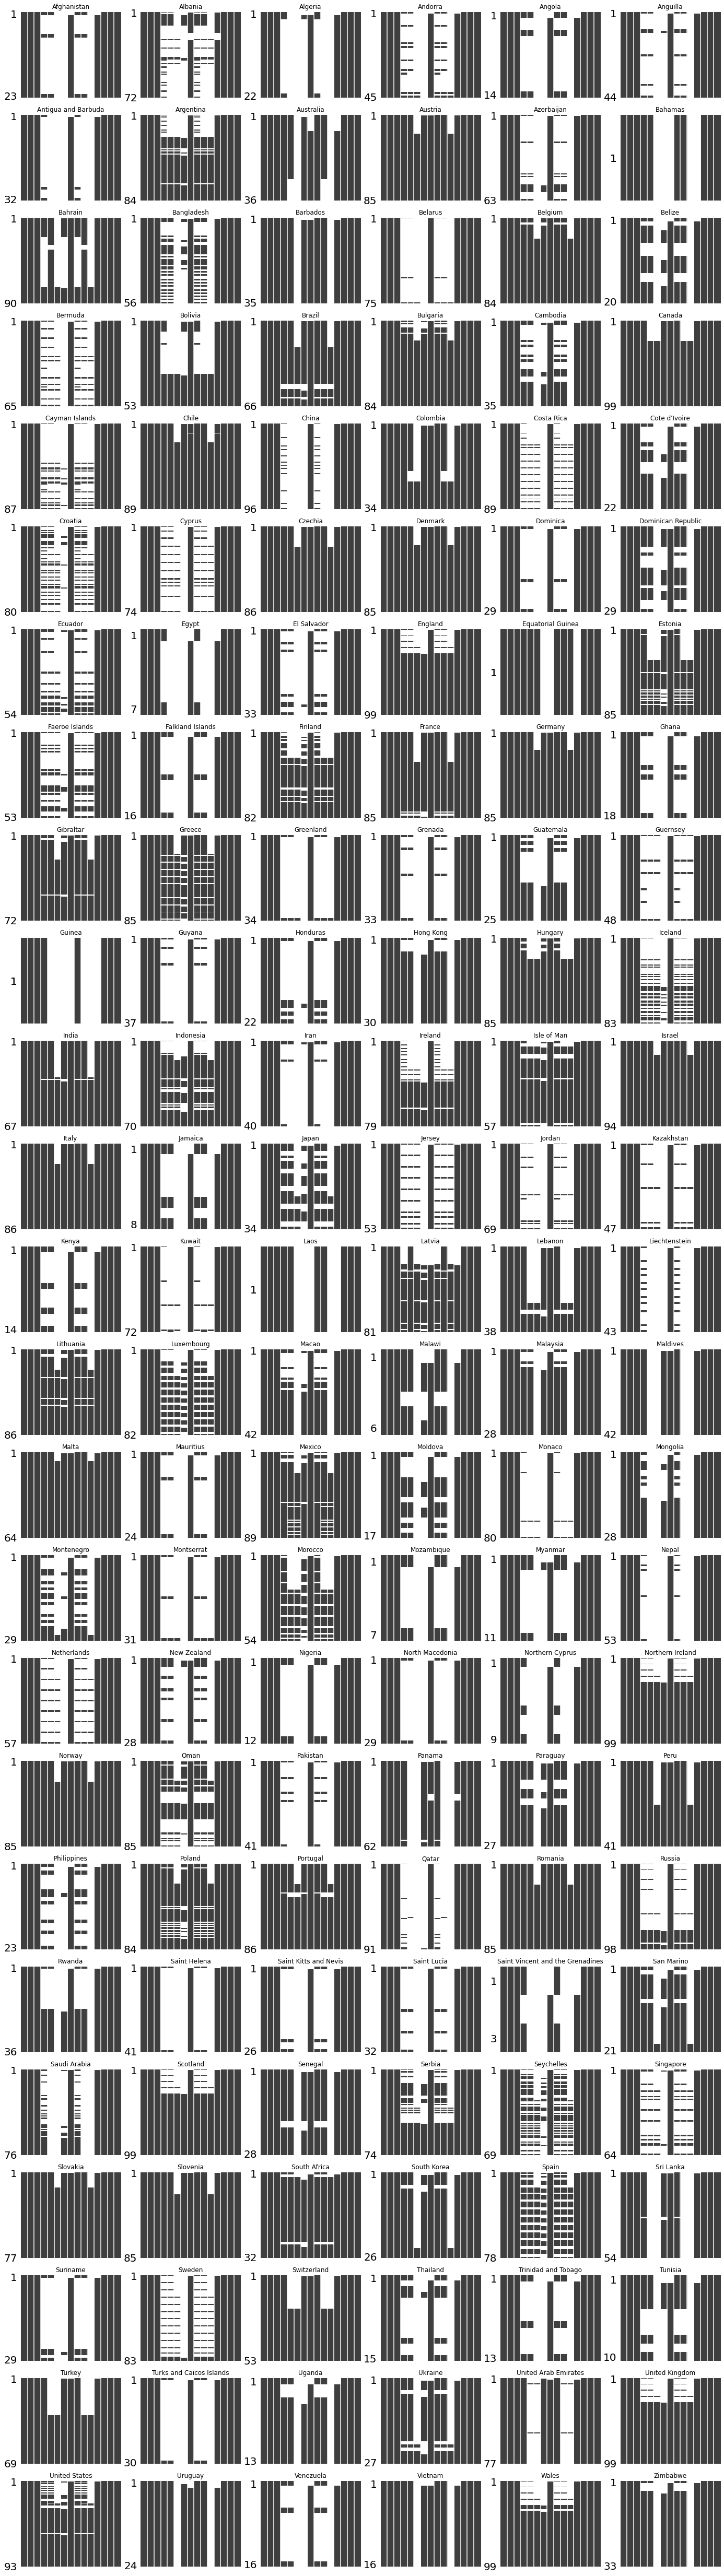

In [ ]:
# Vamos visualizar a distribuição de dados faltantes POR PAÍS
from math import floor

# caso dê problema, é possível que um novo país tenha sido adicionado!
num_rows = 25
num_columns = 6
fig, axarr = plt.subplots(num_rows, num_columns, figsize=(24, 90))

lista_paises = gera_lista_paises(dataset)

for pais in enumerate(lista_paises):
    # extraindo nome e numero do pais
    num_pais = pais[0]
    nome_pais = pais[1]

    # definindo coordenadas de onde no subplot será plotado
    x_plot = floor(num_pais/num_columns)
    y_plot = num_pais % num_columns

    axarr[x_plot][y_plot].set_title(nome_pais)
    msno.matrix(dataset[dataset['pais'] == nome_pais], ax=axarr[x_plot][y_plot], labels=False)

In [ ]:
dataset.describe()

# Código da criação dos gráficos e mapas

In [ ]:
groupby_country = dataset.groupby(['pais'])

listof_dataframe_countries = []
for idx, group in enumerate(groupby_country):
    listof_dataframe_countries.append(group)

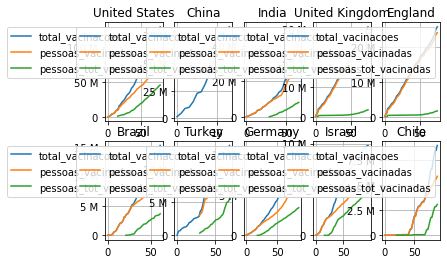

In [ ]:
total_vac_top_countries = pd.DataFrame()
# total_vacinacoes 	pessoas_vacinadas 	pessoas_tot_vacinadas
for i in range(len(listof_dataframe_countries)):
    country_df = listof_dataframe_countries[i][1]
    filtered_df = country_df[country_df['total_vacinacoes'].notna()]
    latest_day_data = filtered_df.iloc[-1:]
    total_vac_top_countries = total_vac_top_countries.append(latest_day_data, ignore_index=True)

total_vac_top_countries = total_vac_top_countries.sort_values(by=['total_vacinacoes'], ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=5)
i = 0
j = 0
for pais in total_vac_top_countries.head(10).iterrows():
    country = dataset[dataset['pais'] == pais[1]['pais']]
    filtered = country[country['total_vacinacoes'].notna()].reset_index()

    fig2 = filtered[['total_vacinacoes','pessoas_vacinadas','pessoas_tot_vacinadas']].plot(title=pais[1]['pais'], ax=axes[j][i], grid=True)
    fig2.yaxis.set_major_formatter(ticker.EngFormatter())
    
    i+=1
    if(i%5 == 0):
        j+=1
        i=0
plt.show()

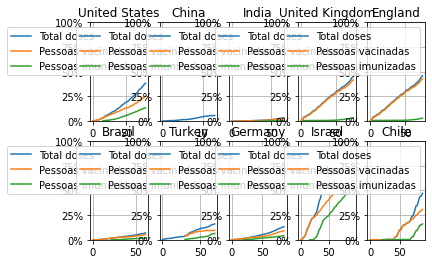

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5)
i = 0
j = 0
for pais in total_vac_top_countries.head(10).iterrows():
    country = dataset[dataset['pais'] == pais[1]['pais']]
    filtered = country[country['tot_vacinacoes_por_cent'].notna()].reset_index()

    fig2 = filtered[['tot_vacinacoes_por_cent','pessoas_vacinadas_por_cent','pessoas_tot_vacinadas_por_cent']].plot(title=pais[1]['pais'], ax=axes[j][i], grid=True)
    fig2.yaxis.set_major_formatter(ticker.PercentFormatter())
    fig2.set_ylim(0, 100)
    fig2.legend(('Total doses', 'Pessoas vacinadas', 'Pessoas imunizadas'))
    
    i+=1
    if(i%5 == 0):
        j+=1
        i=0

plt.show()

In [ ]:
for i in range(len(listof_dataframe_countries)):
    country_name = listof_dataframe_countries[i][0]
    if(country_name in ["United States", "Austria", "Brazil", "United Kingdom"]):
        country_df = listof_dataframe_countries[i][1]
        filtered_df = country_df[country_df['total_vacinacoes'].notna()]
        filtered_df[['total_vacinacoes','pessoas_vacinadas','pessoas_tot_vacinadas']].plot(title=country_name)

plt.show()

In [ ]:
df = pd.DataFrame()

for i in range(len(listof_dataframe_countries)):
    country_name = listof_dataframe_countries[i][0]
    country_df = listof_dataframe_countries[i][1]
    filtered_df = country_df[country_df['pessoas_vacinadas_por_cent'].notna()]
    latest_day_data = filtered_df.iloc[-1:]
    df = df.append(latest_day_data, ignore_index=True)

df.to_csv('./pessoas_vacinadas_por_cent.csv')

fig_pessoas_vacinadas = go.Figure(data=go.Choropleth(
    locations = df['codigo_iso'],
    z = df['pessoas_vacinadas_por_cent'],
    text = df['pais'],
    colorscale = 'YlGnBu',
    autocolorscale=False,
    marker_line_width=0.5,
    colorbar_title = '% pessoas<br>vacinadas',
))
config = {
    'modeBarButtonsToRemove': ['lasso2d','zoomInGeo','zoomOutGeo']
    }

fig_pessoas_vacinadas.update_layout(
    title_text='Covid-19 World Vaccination - Porcentagem de pessoas que tomaram pelo menos uma dose da vacina',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig_pessoas_vacinadas.data[0].update(zmin=0, zmax=60)

fig_pessoas_vacinadas.show(config=config)

In [ ]:
df2 = pd.DataFrame()

for i in range(len(listof_dataframe_countries)):
    country_name = listof_dataframe_countries[i][0]
    country_df = listof_dataframe_countries[i][1]
    filtered_df = country_df[country_df['total_vacinacoes'].notna()]
    latest_day_data = filtered_df.iloc[-1:]
    df2 = df2.append(latest_day_data, ignore_index=True)

df2.to_csv('./total_vacinacoes.csv')

fig_total_doses = go.Figure(data=go.Choropleth(
    locations = df2['codigo_iso'],
    z = df2['total_vacinacoes'],
    text = df2['pais'],
    colorscale = 'Blues',
    autocolorscale=False,
    marker_line_width=0.5,
    colorbar_title = 'Total<br>vacinas<br>(milhões)',
))
config = {
    'modeBarButtonsToRemove': ['lasso2d','zoomInGeo','zoomOutGeo']
    }

fig_total_doses.update_layout(
    title_text='Covid-19 World Vaccination - Total de doses aplicadas',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig_total_doses.show(config=config)

In [ ]:
df3 = pd.DataFrame()

for i in range(len(listof_dataframe_countries)):
    country_name = listof_dataframe_countries[i][0]
    country_df = listof_dataframe_countries[i][1]
    filtered_df = country_df[country_df['vacinacoes_diarias_por_milhao'].notna()]
    latest_day_data = filtered_df.iloc[-1:]
    df3 = df3.append(latest_day_data, ignore_index=True)

df3.to_csv('./vac_diarias_milhao.csv')

fig_vac_diarias_milhao = go.Figure(data=go.Choropleth(
    locations = df3['codigo_iso'],
    z = df3['vacinacoes_diarias_por_milhao'],
    text = df3['pais'],
    colorscale = 'YlGnBu',
    autocolorscale=False,
    reversescale=False,
    marker_line_width=0.5,
    colorbar_title = 'vacinações<br>diárias<br>p/ milhão',
))
config = {
    'modeBarButtonsToRemove': ['lasso2d','zoomInGeo','zoomOutGeo']
    }

fig_vac_diarias_milhao.update_layout(
    title_text='Covid-19 World Vaccination - Vacinações diárias por milhão',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig_vac_diarias_milhao.data[0].update(zmin=500, zmax=15000)

fig_vac_diarias_milhao.show(config=config)